In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
from sklearn.cluster import SpectralClustering
from mvlearn.cluster import MultiviewKMeans
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import sys
import math
import seaborn as sns

sns.set_style("white")
from ConsensusClusteringSingleView import ConsensusCluster
import scipy.stats as sps
import copy
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.lines as mlines
from sklearn.metrics import silhouette_score

In [2]:
PCA = '_PCA_standardized'
data_path = 'data{}/'.format(PCA)
score_path = 'Clustering_silhouette{}/'.format(PCA)
cdf_path = 'CDF plots{}/'.format(PCA)
tsne_path = 'TSNEplots{}/'.format(PCA)

# KCC space = KMeans cluster

In [ ]:
perf = pd.DataFrame(columns=["View", "K", "silhouette"])
f = 1
for view in ['clinical', 'contextual', 'physio', 'proteome']:
    Mks = []
    Aks = []
    assignments = pd.DataFrame(columns=range(2, 21))
    for kcc_space in range(2, 21):
        data = pd.read_csv(
            "{}/KCC_Cov_AgeSexEth_{}_PCA_NormalImputation_PCA95%_K{}.csv".format(data_path, view, kcc_space), header=None, 
        )

        assert data.shape == (387, kcc_space)
        cons = ConsensusCluster(KMeans, kcc_space, kcc_space + 1, 100, resample_proportion=0.8)
        cons.fit(data)
        assignments[kcc_space] = cons.predict_data(data) + 1
        assert cons.Mk.shape[0] == 1
        Mks.append(cons.Mk[0])
        score = silhouette_score(data.values, assignments[kcc_space])
        entry = [view, kcc_space, score]
        perf.loc[f] = entry
        f += 1
        
    assignments.to_csv("{}/ConsensusAssignments_Cov_AgeSexEth_{}_NormalImputation_PCA95%.csv".format(data_path, view))

    
    Aks = []
    plt.figure(figsize=(20, 15))
    for kcc_space in range(2, 21):
        hist, bins = np.histogram(Mks[kcc_space - 2].ravel(), bins=50)
        pdf = hist / sum(hist)
        cdf = np.cumsum(pdf)
        acdf = np.sum(h * (b - a) for b, a, h in zip(bins[1:], bins[:-1], cdf))
        Aks.append(acdf)
        plt.plot(bins[1:], cdf, label=kcc_space)

    plt.legend(fontsize=16)
    plt.title("CDF: {} view".format(view), fontsize=25)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig('{}/Cov_AgeSexEth_{}_NormalImputation_PCA95%.png'.format(cdf_path, view), dpi=300)
    plt.show()


perf.to_csv('{}/KCC_ConsensusKMeans_KCCSpace_equal_KMeans.csv'.format(score_path))

In [ ]:
plt.figure(figsize=(24, 20))
j = 1
for view in ["clinical", "contextual", "physio", "proteome"]:
    perf = pd.DataFrame(columns=["View", "K", "perplexity", "random_state", "silhouette"])
    i = 1
    assignment = pd.read_csv(
        "{}/ConsensusAssignments_Cov_AgeSexEth_{}_NormalImputation_PCA95%.csv".format(
            data_path, view
        ),
        index_col=0,
    )
    assert assignment.shape == (387, 19)
    for K in range(2, 21):
        data = pd.read_csv(
            "{}/KCC_Cov_AgeSexEth_{}_PCA_NormalImputation_PCA95%_K{}.csv".format(
                data_path, view, K
            ),
            header=None,
        )
        assert data.shape == (387, K)
        for perplexity in [5, 10, 20, 30]:
            for random_state in range(10):
                tsne = TSNE(
                    perplexity=perplexity, random_state=random_state, n_components=2
                )
                X_emb = tsne.fit_transform(data.values)

                assert X_emb.shape[1] == 2

                score = silhouette_score(X_emb, assignment.loc[:, str(K)].tolist(),)

                perf.loc[i] = [view, K, perplexity, random_state, score]
                i += 1
                
    perf.sort_values("silhouette", ascending=False).to_csv(
        "{}/TSNE_ConsensusKMeans_CovPCA_AgeSexEth_{}.csv".format(score_path, view)
    )

# visualize the highest silhouette score

In [3]:
perf = pd.read_csv(
    "{}/KCC_ConsensusKMeans_KCCSpace_equal_KMeans.csv".format(score_path),
    index_col=0,
)
view = 'clinical'
perf = perf[(perf['K'] != 2) & (perf['View'] == view)]

View          clinical
K                    3
silhouette       0.369
Name: 2, dtype: object

View          contextual
K                      3
silhouette         0.432
Name: 21, dtype: object

View          physio
K                  3
silhouette     0.416
Name: 40, dtype: object

View          proteome
K                    3
silhouette       0.379
Name: 59, dtype: object

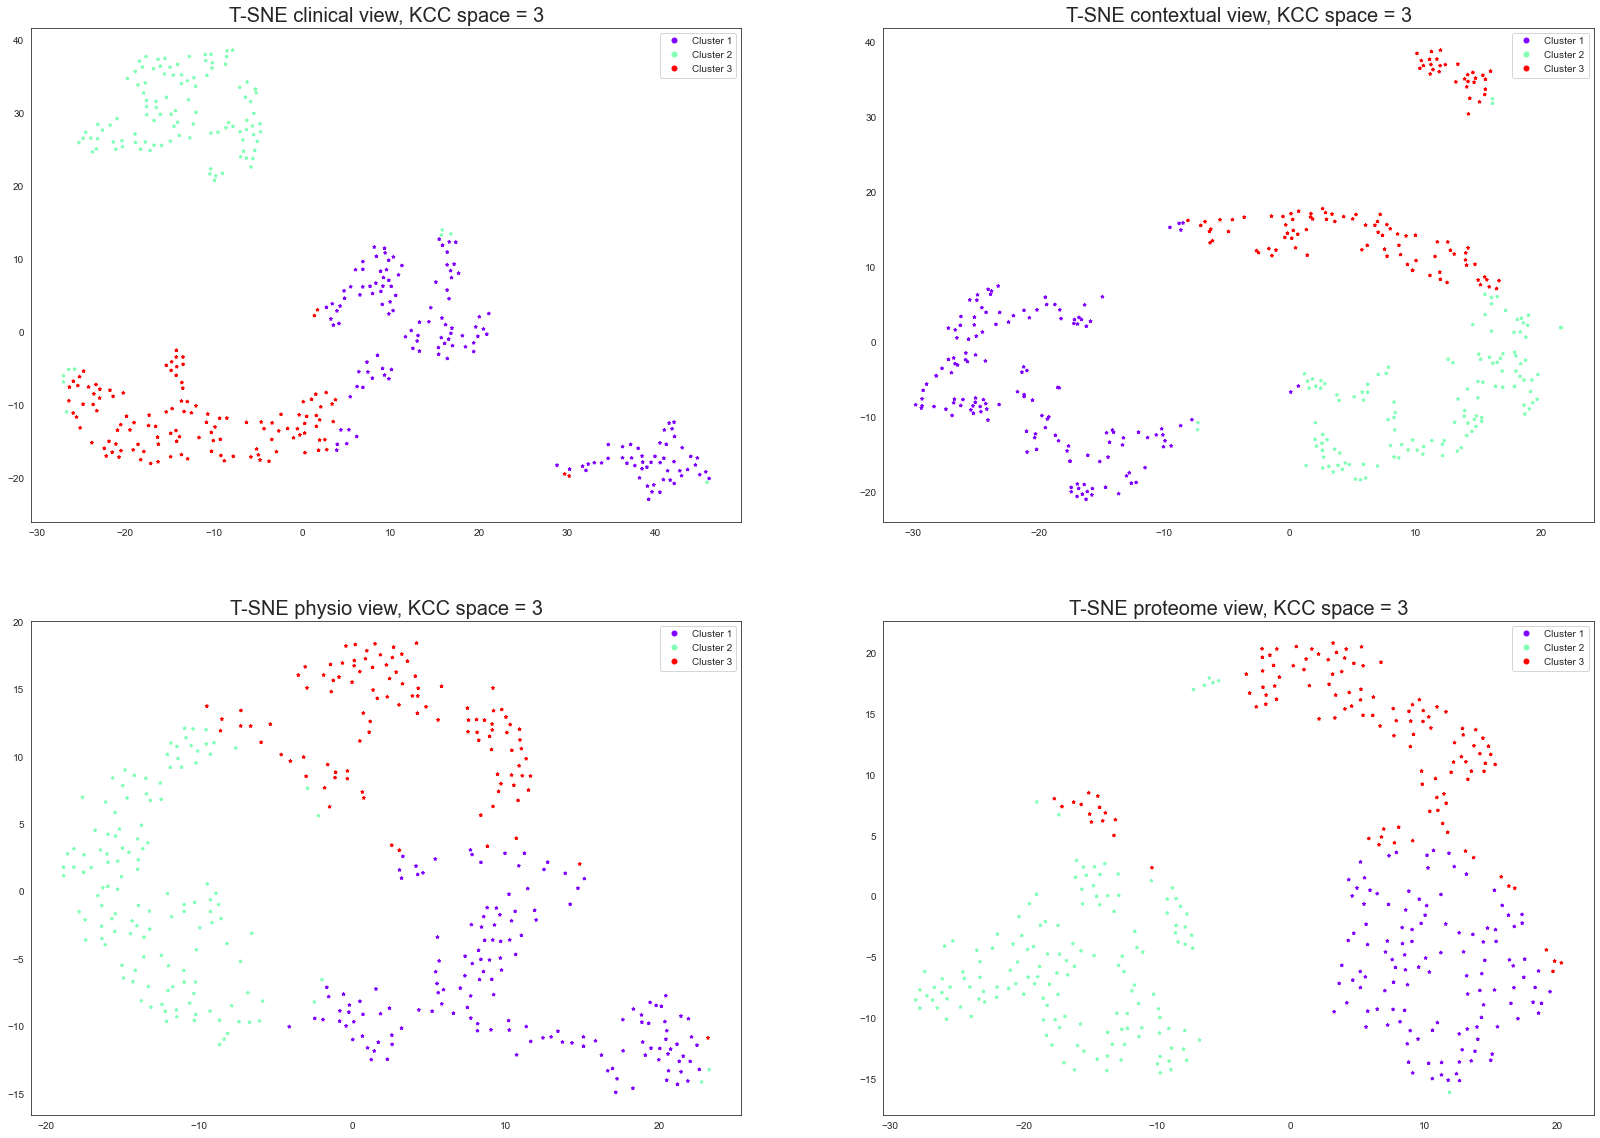

In [4]:
plt.figure(figsize=(28, 20))
j = 1
for view in ["clinical", "contextual", "physio", "proteome"]:

    perf = pd.read_csv(
        "{}/KCC_ConsensusKMeans_KCCSpace_equal_KMeans.csv".format(score_path, view),
        index_col=0,
    )

    perf_sub = (
        perf[(perf["K"] != 2) & (perf["View"] == view)]
        .sort_values("silhouette", ascending=False)
        .iloc[0]
    )
    display(perf_sub)
    
    K = perf_sub['K']

    assignment = pd.read_csv(
        "{}/ConsensusAssignments_Cov_AgeSexEth_{}_NormalImputation_PCA95%.csv".format(
            data_path, view
        ),
        index_col=0,
    )
    assignment = assignment.loc[:, str(K)]
    
    data = pd.read_csv(
        "{}/KCC_Cov_AgeSexEth_{}_PCA_NormalImputation_PCA95%_K{}.csv".format(
            data_path, view, K
        ),
        header=None,
    )
    assert data.shape == (387, K)
    plt.subplot(2, 2, j)
    if K >= 3:
        best_score = 0
        for perplexity in [5, 10, 20, 30]:
            for random_state in range(10):
                tsne = TSNE(
                    perplexity=perplexity, random_state=random_state, n_components=2
                )
                X_emb = tsne.fit_transform(data.values)

                score = silhouette_score(X_emb, assignment)

                if score > best_score:
                    best_score = score
                    best_emb = X_emb
                    

        legends = []
        cmap = cm.rainbow(np.linspace(0, 1, K))
        colors = np.array([cmap[i - 1] for i in assignment])
        for i in range(K):
            legends.append(
                mlines.Line2D(
                    [],
                    [],
                    color=cmap[i],
                    marker=".",
                    linestyle="None",
                    markersize=10,
                    label="Cluster {}".format(i + 1),
                )
            )
        plt.scatter(
            best_emb[:, 0],
            best_emb[:, 1],
            color=colors,
            s=10,
            marker="*",
        )
        plt.title(
            "T-SNE {} view, KCC space = {}".format(
                view, K
            ),
            fontsize=20,
        )
        plt.legend(handles=legends, fontsize=10)

    elif K == 2:
        legends = []
        cmap = cm.rainbow(np.linspace(0, 1, K))
        colors = np.array([cmap[i - 1] for i in assignment])
        for i in range(K):
            legends.append(
                mlines.Line2D(
                    [],
                    [],
                    color=cmap[i],
                    marker=".",
                    linestyle="None",
                    markersize=10,
                    label="Cluster {}".format(i + 1),
                )
            )
        plt.scatter(
            data.values[:, 0],
            data.values[:, 1],
            color=colors,
            s=10,
            marker="*",
        )
        plt.title(
            "2D {} view, KCC space = {}".format(view, K),
            fontsize=20,
        )
        plt.legend(handles=legends, fontsize=10)
        
    j += 1

plt.savefig(
    "{}/CovPCA_AgeSexEth_ConsensusKMeans_BestSilhouette.png".format(tsne_path), dpi=300
)

plt.show()

# select by visual inspection

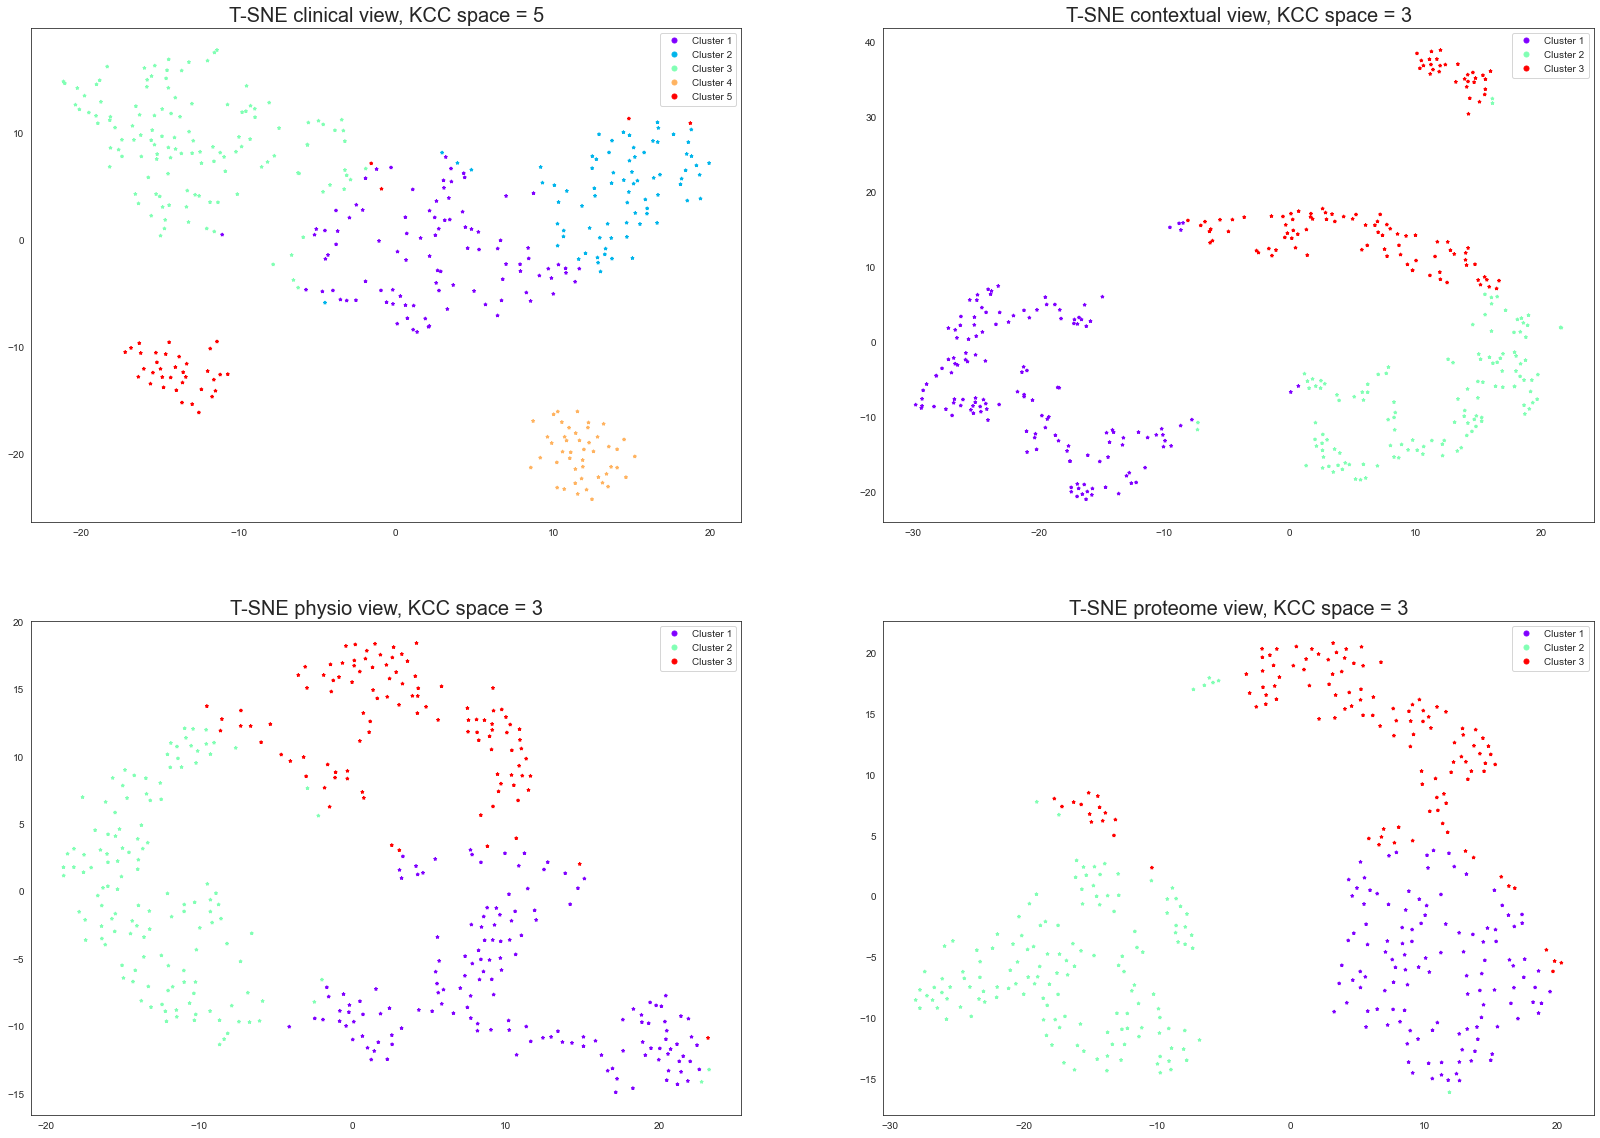

In [5]:
plt.figure(figsize=(28, 20))
j = 1
if PCA == '':
    best_K = {}
    best_K['clinical'] = 3
    best_K['contextual'] = 5
    best_K['physio'] = 4
    best_K['proteome'] = 3
elif PCA == '_PCA_standardized':
    best_K = {}
    best_K['clinical'] = 5
    best_K['contextual'] = 3
    best_K['physio'] = 3
    best_K['proteome'] = 3
    
for view in ["clinical", "contextual", "physio", "proteome"]:

    
    K = best_K[view]

    assignment = pd.read_csv(
        "{}/ConsensusAssignments_Cov_AgeSexEth_{}_NormalImputation_PCA95%.csv".format(
            data_path, view
        ),
        index_col=0,
    )
    assignment = assignment.loc[:, str(K)]
    
    data = pd.read_csv(
        "{}/KCC_Cov_AgeSexEth_{}_PCA_NormalImputation_PCA95%_K{}.csv".format(
            data_path, view, K
        ),
        header=None,
    )
    assert data.shape == (387, K)
    plt.subplot(2, 2, j)
    if K >= 3:
        best_score = 0
        for perplexity in [5, 10, 20, 30]:
            for random_state in range(10):
                tsne = TSNE(
                    perplexity=perplexity, random_state=random_state, n_components=2
                )
                X_emb = tsne.fit_transform(data.values)

                score = silhouette_score(X_emb, assignment)

                if score > best_score:
                    best_score = score
                    best_emb = X_emb
                    

        legends = []
        cmap = cm.rainbow(np.linspace(0, 1, K))
        colors = np.array([cmap[i - 1] for i in assignment])
        for i in range(K):
            legends.append(
                mlines.Line2D(
                    [],
                    [],
                    color=cmap[i],
                    marker=".",
                    linestyle="None",
                    markersize=10,
                    label="Cluster {}".format(i + 1),
                )
            )
        plt.scatter(
            best_emb[:, 0],
            best_emb[:, 1],
            color=colors,
            s=10,
            marker="*",
        )
        plt.title(
            "T-SNE {} view, KCC space = {}".format(
                view, K
            ),
            fontsize=20,
        )
        plt.legend(handles=legends, fontsize=10)

    elif K == 2:
        legends = []
        cmap = cm.rainbow(np.linspace(0, 1, K))
        colors = np.array([cmap[i - 1] for i in assignment])
        for i in range(K):
            legends.append(
                mlines.Line2D(
                    [],
                    [],
                    color=cmap[i],
                    marker=".",
                    linestyle="None",
                    markersize=10,
                    label="Cluster {}".format(i + 1),
                )
            )
        plt.scatter(
            data.values[:, 0],
            data.values[:, 1],
            color=colors,
            s=10,
            marker="*",
        )
        plt.title(
            "2D {} view, KCC space = {}".format(view, K),
            fontsize=20,
        )
        plt.legend(handles=legends, fontsize=10)
        
    j += 1

plt.savefig(
    "{}/CovPCA_AgeSexEth_ConsensusKMeans_VisualInspectCDF.png".format(tsne_path), dpi=300
)

plt.show()